# Comparação entre dados de COVID-19 divulgados para a cidade de Indaiatuba entre Governo SP e Prefeitura. 

Neste projeto iremos fazer uma comparação entre os dados do numero de casos e obitos divulgados entre a prefeitura de Indaiatuba e os dados divulgados pelo governo do estado de SP. No Brasil o numero de casos do novo coronavirus vem crescendo dia após dia, sendo hoje o segundo país do mundo com o maior numero casos de COVID-19 (25/05/2020), e o estado de São Paulo é o estado com o maior numero de casos e obitos quando comparamos os valores absolutos.

Quando analisamos dados municipais em relação aos dados do estado de SP é possivel ver uma disparidade entre os valores, uma reportagem da Globo foi feita questionando esses dados para municipios da Grade SP - https://glo.bo/3bZbHjC, em nota a secretaria disse que os municípios são responsáveis pela investigação e notificação dos casos de Covid-19, e que os horarios de notificação do estado e dos municipios são diferentes, por isso pode difererir.

Como a prefeitura não disponibiliza os dados em formato de arquivo para download, então é necessario fazer um web scrapy das noticias postadas no site da prefeitura https://www.indaiatuba.sp.gov.br/relacoes-institucionais/imprensa/acoes-e-obras/acao/1216/ e para os dados do governo de São Paulo está disponivel no repósitorio do github https://github.com/seade-R/dados-covid-sp.

Importantando as bibliotecas utilizadas

In [1]:
#Bibliotecas para fazer web scrapy dos sites
import requests
from requests import get
from bs4 import BeautifulSoup

#trabalhar com data frame
import pandas as pd

#Biblioteca para o processamento de linguagem
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.util import bigrams


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Para a primeira parte do processo, foi utilizado a url contendo todas as notícias relacionda a cidade de Indaiatuba, com isso separamos as notícias relacionado a COVID-19 que contêm dados com óbitos e casos confirmados.

In [2]:
url = "https://www.indaiatuba.sp.gov.br/relacoes-institucionais/imprensa/acoes-e-obras/acao/1216/"

results = requests.get(url)

soup = BeautifulSoup(results.text, "html.parser")

sites = []

div_sit = soup.find_all('div', class_='post_acao')

for container in div_sit:

   aux = container.h4.a
   if aux.text[0:15] == 'NOTA - COVID-19':
     sites.append('https://www.indaiatuba.sp.gov.br' + aux['href'])
 
sites.remove("https://www.indaiatuba.sp.gov.br/relacoes-institucionais/imprensa/noticias/28430/")
sites.remove("https://www.indaiatuba.sp.gov.br/relacoes-institucionais/imprensa/noticias/28486/")

Com a lista de url's, é possivel fazer a retirada da descrição presente no site, assim como as datas de publicações.

In [3]:
descricao = []
datas = []

for i in sites:
  url1 = i
  results1 = requests.get(url1)

  soup1 = BeautifulSoup(results1.text, "html.parser")

  div_sit1 = soup1.find_all('div', class_='grid-75 content')

  for container1 in div_sit1:
    
    inside_ul = container1.find_all('ul', {'class':'info_noticia'})
    get_all_text = inside_ul[0].find('li').text
    finda_date = re.search(r'\d{2}/\d{2}/\d{4}',get_all_text)
    datas.append(finda_date.group())

    str_free = ''
    aux_des = container1.findAll('p')

    for strin in aux_des:
      str_free = str_free + ' ' + strin.text
 
    descricao.append(str_free)

Antes de iniciar o processamento de retirada dos dados, vamos definir algumas funções para nos auxiliar no pré-processamento.

In [4]:
#Função que utiliza Bigrams para encontrar valores numericos indesejados, retornando seu indice
def Limpando_Bigrams(splitBiog,word_bigram,delnext):
  aux_bi = []
  for i in range(0,len(splitBiog)):
    if  splitBiog[i] == word_bigram:
      if delnext == 'before':
        aux_bi.append(i-1)
      else:
        aux_bi.append(i+2)
  return(aux_bi)

#Função para retirar dia, ano e nome de mês
def Limpando_Data(List_split_word,take_off_word):
  list_index = []
  for i in range(0,len(List_split_word)-1):
    if List_split_word[i].isdigit():
      if List_split_word[i+1] in take_off_word:
        list_index.append(i)
      if List_split_word[i-1] in take_off_word:

        list_index.append(i)
  return(list_index)

#Função que retira um character da sequencia da palavra escolhida (oneword) 
def Taking_out_singleW(listword,oneword):
  aux_oneword = []
  for i in range(0,len(listword)):
    if listword[i] == oneword:
      aux_oneword.append(i+1)
  return(DeletingIndex(tesW,aux_oneword))

#Função para retirada dos dados para o caso dos óbitos vamos tirar o menor valor da lista e os casos confirmados o maior.
def Arruman(list1,flagminmax):
  aux2 = []
  for ins in list1:
    if ins.isdigit():
      aux2.append(ins)
  aux2 = list(map(int,aux2))
  if len(aux2) > 0:
    if flagminmax == 'min':
      value = min(aux2)
    else:
      value = max(aux2)
  else:
    value = 0
  return(value)  

  #Função que utiliza o indice para retirar da lista a palavra
def DeletingIndex(splitlist,IndexList):
  if len(IndexList) > 0 :
    splitlist = [i for j, i in enumerate(splitlist) if j not in IndexList]
  return(splitlist)

Após definir todas funções que irao nós auxiliar e com as strings contendo a informação necessaria de todos os sites, vamos fazer um pré processamento para poder retirar essas informações do modo correto.

In [5]:
# Alguns vetores de palavras que vão ser retiradas ou trocadas dentro do nosso texto.
word = ['notificações','confirmados','óbito','curados','internados','clínico','uti','anos','masculino','março','abril','maio','junho','julho','positivos','suspeitos']
word_out = ['anos','dia','horas','dias','ano']
singles_out = ['exame','acrescentadas','somando','cidades','igual','constatou','outros','hoje']
words_to_replace = ['.',',',';','-','infectados','mortes','faleceram','curas','óbitos']
replace_to = ['','','','','confirmados','óbito','óbito','curados','óbito']

#Assim como foi feito a troca das palavras numericas para os prorios numeros em si
word_after_number =['zero','dois','três','quatro','cinco','seis','sete','oito','nove']
num2words = {'um':1,'dois' : 2,'três': 3, 'quatro':4,'cinco':5, \
             'seis':6, 'sete':7,'oito' : 8,'nove':9,'dez':10,'zero': 0}

#Utilizamos os bigrams (conjunto de duas palavras) para retirar alguns numeros não condizentes ao nosso texto
tuples_out = [("óbito","investigação"),('óbitos', 'haoc'),('ainda', 'aguardam'),('óbito', 'ocorreram')]


obito = []
confirmados = []

#Podemos considerar essa parte a nossa função principal, onde é feito a limpeza dos dados até chegar nos valores finais.
for des in descricao:

  transf = des
  #retirandos pontos e trocando palavras que tem o mesmo significado
  for ind_word in range(0,len(words_to_replace)):
    transf = transf.replace(words_to_replace[ind_word],replace_to[ind_word])

  tesW = transf.lower().split()
  tesW = Taking_out_singleW(tesW,'mais')
  tesW = DeletingIndex(tesW,Limpando_Data(tesW,word_out))

  #retirando palavras comuns como e, de, com, em ...
  tesW = [word for word in tesW if not word in stopwords.words()]

  #retirando numeros que podem atrapalhar na obtenção dos dados, utilizando bigrams
  for tuples in tuples_out:
    tesW = DeletingIndex(tesW,Limpando_Bigrams(list(bigrams(tesW)),tuples,'before'))
  
  tesW = DeletingIndex(tesW,Limpando_Bigrams(list(bigrams(tesW)),('residentes', 'indaiatuba'),'next'))
  
  #fazendo a troca das palavras relacionadas a número para o número em si
  for t in range(0,len(tesW)):
    if tesW[t] in word_after_number:
      tesW[t] = str(num2words[tesW[t]])
  
  #retirando numeros relacionados com palavras sozinas
  for single in singles_out:
    tesW = Taking_out_singleW(tesW,single)
  
  #Utilizando datas para tirar listas enumeradas.
  total = ' '.join(tesW)
  s = re.search(r'\d{2}/\d{2}', total)
  while s != None:
    aux_dat = s.group()
    tesW = DeletingIndex(tesW,Limpando_Bigrams(list(bigrams(tesW)),('óbito', aux_dat),'before'))
    tesW.remove(aux_dat)
    total = ' '.join(tesW)
    s = re.search(r'\d{2}/\d{2}', total)

  #No fim retirandos todas as palvras deixando apenas os numeros e as palavras contidas no vetor word
  Choose_words = (' '.join([i for i in tesW if i  in word or i.isnumeric()]))
  split_words = Choose_words.split()


  obito_aux = []
  confirmados_aux = []

  #Retirando os dados em si do que sobrou da string
  for i in range(0,len(split_words)):

    if(split_words[i] in 'óbito'):
      obito_aux.append(split_words[i-1])
    if(split_words[i] in 'confirmados'):
      confirmados_aux.append(split_words[i-1])

 
  obito.append(Arruman(obito_aux,'min'))
  confirmados.append(Arruman(confirmados_aux,'max'))


Nessa primeira abordagem utilizando web scrape foi retirado apenas informações relacionadas ao número de Casos e de óbitos disponibilizados pelo site da prefeitura de Indaiatuba.
Vamos Transformar em um Data Frame, além disso podemos calcular o número de casos e óbitos por dia, apenas fazendo a subtração dos valores no tempo
t - (t-1)

In [6]:
import numpy as np

#Visualização dos dados
import cufflinks as cf
from plotly.offline import plot, iplot

import matplotlib.pyplot as plt
import plotly.graph_objects as go

#Para trabalhar com datas/horas
import datetime

#Criando o conjunto de dados relacionado a COVID-19 da prefeitura de SP
Dados_Indaiatuba = pd.DataFrame()
Dados_Indaiatuba['Data'] = list(reversed(datas))
Dados_Indaiatuba['Obitos'] = list(reversed(obito))
Dados_Indaiatuba['Casos_Positivos'] = list(reversed(confirmados))
Dados_Indaiatuba['Letalidade'] = (Dados_Indaiatuba.Obitos/Dados_Indaiatuba.Casos_Positivos)*100

#Fazendo o calculo de casos e óbitos por dia, fazendo a subtração entre o dado no tempo t e o tempo anterior t-1
Obitos_Per_day = [Dados_Indaiatuba.Obitos.values[0]]
Positivos_per_day = [Dados_Indaiatuba.Casos_Positivos.values[0]]

for i in range(1,len(Dados_Indaiatuba.Obitos.values)):
  Obitos_Per_day.append(Dados_Indaiatuba.Obitos.values[i] - Dados_Indaiatuba.Obitos.values[i-1])
  Positivos_per_day.append(Dados_Indaiatuba.Casos_Positivos.values[i] - Dados_Indaiatuba.Casos_Positivos.values[i-1])

Dados_Indaiatuba['Obitos_per_day'] = Obitos_Per_day
Dados_Indaiatuba['Casos_Positivos_per_day'] = Positivos_per_day



Bad key "text.kerning_factor" on line 4 in
C:\Users\gusta\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


Para fazer a comparação com os dados do governo do estado de SP, vamos utilizar os dados disponiveis no repositorio do github do Seade-SP https://github.com/seade-R/dados-covid-sp.
O conjunto de dados contem valores para todos os municipios do estado de SP, e o formato do tempo que estão utilizando é o dos Estados unidos, logo foi feitos alguns ajustes para trabalhar com os dados.

In [7]:
#Chamando os dados do Governo no github 
Dados_governo = pd.read_csv('https://raw.githubusercontent.com/seade-R/dados-covid-sp/master/data/dados_covid_sp.csv',sep = ';',decimal=",")

#Mudando o formato de data que estava 2020-04-24 para o nosso 24/04/2020.
Date_wrong_format = Dados_governo.datahora.values
Date_right = []
for date in Date_wrong_format:
  Date_right.append(datetime.datetime.strptime(date, '%Y-%m-%d').strftime('%d/%m/%Y'))

Dados_governo.datahora = Date_right

Como podemos notar o conjunto de dados do governo tem dados de todos os municipios, vamos separar para Indaiatuba. Deixando apenas as colunas de Data , Casos Positivos, Casos Positivos por dia, Óbito e Óbitos por dia

In [8]:
#Como nossa comparação é com o municipio de indaiatuba, vamos separar nossos dados
Dados_governo2 = Dados_governo.query("nome_munic == 'Indaiatuba'")
Dados_Governo_Indaiatuba = Dados_governo2[["datahora","casos","casos_novos","obitos","obitos_novos","letalidade"]]
Dados_Governo_Indaiatuba.columns = ["Data","Casos_Positivos","Casos_por_dia","Obitos","Obitos_por_dia","Letalidade"]
Dados_Governo_Indaiatuba.Letalidade = Dados_Governo_Indaiatuba.Letalidade*100

#Visualização dos Dados

Vamos agora utilizar o pacote plotly para fazer a visualização dos dados.

Foi feito o plote do gráfico entre Casos de Covid por dia e Numero de mortos por dia. Podemos notar que o numero de casos por dia  em alguns momentos chegam a ser quatro vezes mais para o dado da prefeitura e crescem de uma forma mais veloz, enquanto pelos dados do Governo parece manter dentro dentro um intervalo de variação.

Quando olhamos para o número de mortos temos que os dois estão proximos, com variações parecidas entre eles, com picos de mortes em alguns dias para o Governo.

Depois que foi implantado o plano SP que a região de Indaiatuba entrou na Fase 2 (https://www.saopaulo.sp.gov.br/planosp/) tivemos um aumento no número de casos, para os dois cenarios entretando foi maior para os dados da Prefeitura porém não de mortes.

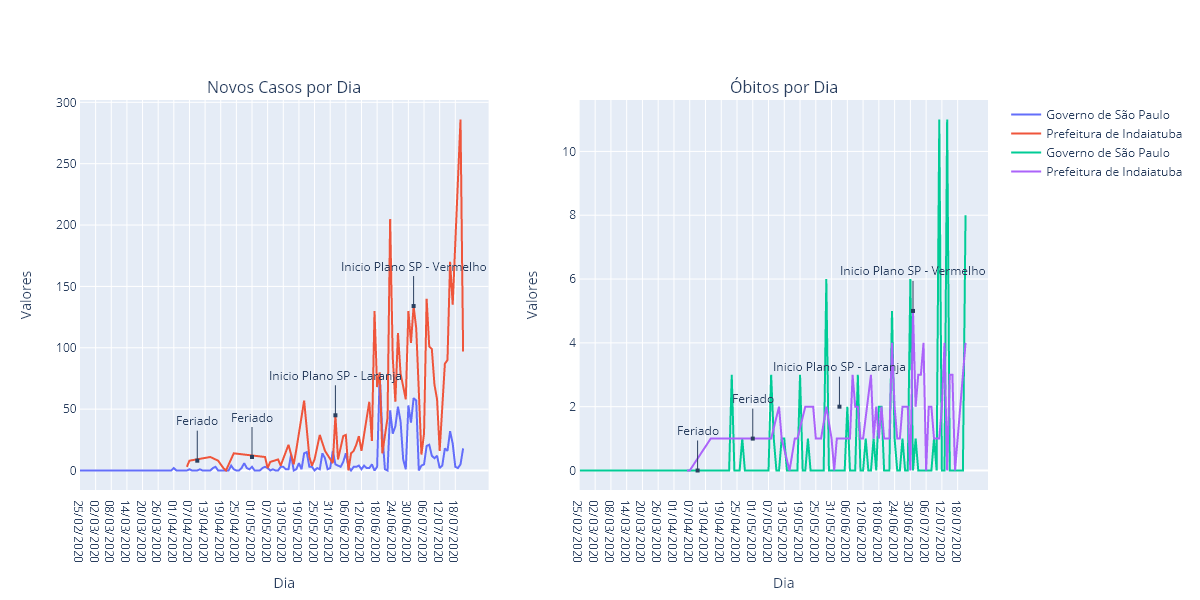

In [45]:
from plotly.subplots import make_subplots
#Foi criado um subplot para plotar na mesma figura os dois graficos
fig = make_subplots(rows=1, cols=2,subplot_titles = ["Novos Casos por Dia","Óbitos por Dia"])

#Adicionar ao mesmo Grafico duas linhas
fig.add_trace(go.Scatter(x = Dados_Governo_Indaiatuba.Data, y = Dados_Governo_Indaiatuba.Casos_por_dia, mode = "lines" ,name = "Governo de São Paulo"),row=1, col=1)
fig.add_trace(go.Scatter(x = Dados_Indaiatuba.Data, y = Dados_Indaiatuba.Casos_Positivos_per_day, mode = "lines" ,name = "Prefeitura de Indaiatuba"),row=1, col=1)

#Adicionar anotações dentro do grafico
fig.add_annotation(x="10/04/2020",y=8,text="Feriado",xref="x", yref="y",showarrow=True,arrowhead=7,ax=0,ay=-40)
fig.add_annotation(x="01/05/2020",y=11,text="Feriado",xref="x", yref="y",showarrow=True,arrowhead=7,ax=0,ay=-40)
fig.add_annotation(x="02/06/2020",y=45,text="Inicio Plano SP - Laranja",xref="x", yref="y",showarrow=True,arrowhead=7,ax=0,ay=-40)
fig.add_annotation(x="02/07/2020",y=134,text="Inicio Plano SP - Vermelho",xref="x", yref="y",showarrow=True,arrowhead=7,ax=0,ay=-40)

#Entrar no segundo Grafico
fig.add_trace(go.Scatter(x = Dados_Governo_Indaiatuba.Data, y = Dados_Governo_Indaiatuba.Obitos_por_dia, mode = "lines" ,name = "Governo de São Paulo"), row=1, col=2)
fig.add_trace(go.Scatter(x = Dados_Indaiatuba.Data, y = Dados_Indaiatuba.Obitos_per_day, mode = "lines" ,name = "Prefeitura de Indaiatuba"), row=1, col=2)

#Adicionar anotações dentro do grafico
fig.add_annotation(x="10/04/2020",y=0,text="Feriado",xref="x2", yref="y2",showarrow=True,arrowhead=7,ax=0,ay=-40)
fig.add_annotation(x="01/05/2020",y=1,text="Feriado",xref="x2", yref="y2",showarrow=True,arrowhead=7,ax=0,ay=-40)
fig.add_annotation(x="03/06/2020",y=2,text="Inicio Plano SP - Laranja",xref="x2", yref="y2",showarrow=True,arrowhead=7,ax=0,ay=-40)
fig.add_annotation(x="01/07/2020",y=5,text="Inicio Plano SP - Vermelho",xref="x2", yref="y2",showarrow=True,arrowhead=7,ax=0,ay=-40)

#Mudar a escrita dos eixos
fig.update_xaxes(title_text="Dia", row=1, col=1)
fig.update_xaxes(title_text="Dia", row=1, col=2)
fig.update_yaxes(title_text="Valores", row=1, col=1)
fig.update_yaxes(title_text="Valores", row=1, col=2)

fig.show(renderer="png" , width=1200, height=600)

Plotando os Casos  acumulados podemos notar que os valores são mais preocupantes, tendo uma diferença consideravel desde do final de Maio e essa diferença só vem crescendo hoje chega a ser superior de 300%. Para o número de mortes o valor da prefeitura sempre foi superior mas em torno de 40% acima.

Nesse Grafico fica mais facil notar que tanto o feriado antecipado (https://g1.globo.com/jornal-nacional/noticia/2020/05/18/sao-paulo-decide-antecipar-feriados-para-combater-pandemia.ghtml) quanto o plano SP não foi eficaz. 

O principal motivo foi que as pessoas começaram a sair novamente pois o comercio voltou de forma reduzida porém voltou a funcionar.

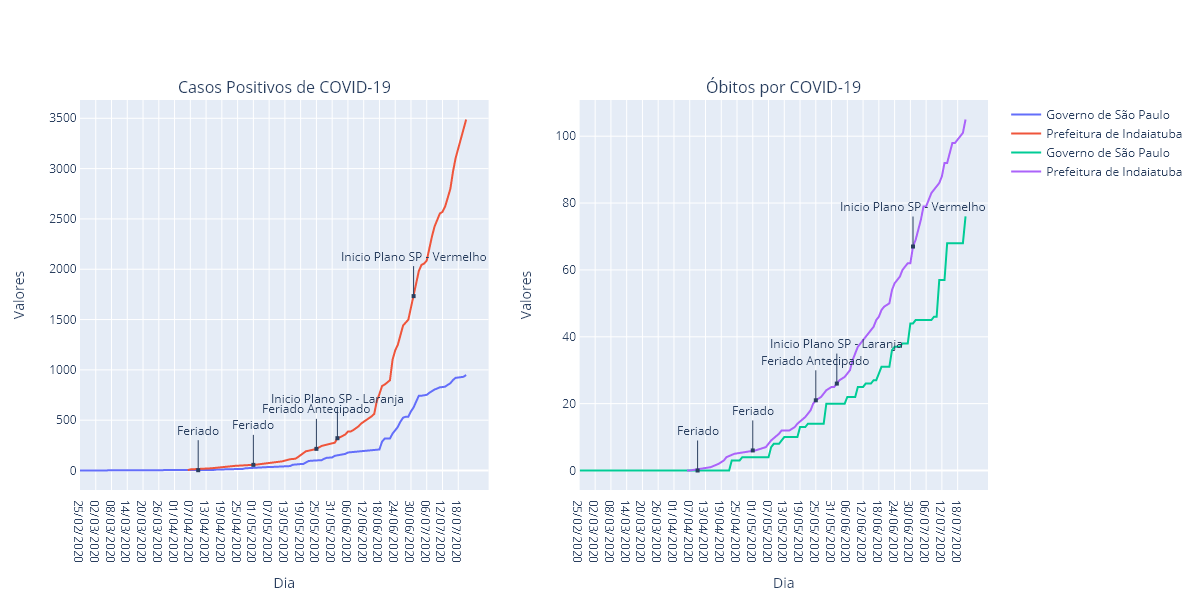

In [44]:
fig = make_subplots(rows=1, cols=2,subplot_titles = ["Casos Positivos de COVID-19","Óbitos por COVID-19"])

fig.add_trace(go.Scatter(x = Dados_Governo_Indaiatuba.Data, y = Dados_Governo_Indaiatuba.Casos_Positivos, mode = "lines" ,name = "Governo de São Paulo"),row=1, col=1)
fig.add_trace(go.Scatter(x = Dados_Indaiatuba.Data, y = Dados_Indaiatuba.Casos_Positivos, mode = "lines" ,name = "Prefeitura de Indaiatuba"),row=1, col=1)

fig.add_annotation(x="10/04/2020",y=3,text="Feriado",xref="x", yref="y",showarrow=True,arrowhead=7,ax=0,ay=-40)
fig.add_annotation(x="01/05/2020",y=56,text="Feriado",xref="x", yref="y",showarrow=True,arrowhead=7,ax=0,ay=-40)
fig.add_annotation(x="25/05/2020",y=215,text="Feriado Antecipado",xref="x", yref="y",showarrow=True,arrowhead=7,ax=0,ay=-40)
fig.add_annotation(x="02/06/2020",y=321,text="Inicio Plano SP - Laranja",xref="x", yref="y",showarrow=True,arrowhead=7,ax=0,ay=-40)
fig.add_annotation(x="01/07/2020",y=1733,text="Inicio Plano SP - Vermelho",xref="x", yref="y",showarrow=True,arrowhead=7,ax=0,ay=-40)

fig.add_trace(go.Scatter(x = Dados_Governo_Indaiatuba.Data, y = Dados_Governo_Indaiatuba.Obitos, mode = "lines" ,name = "Governo de São Paulo"), row=1, col=2)
fig.add_trace(go.Scatter(x = Dados_Indaiatuba.Data, y = Dados_Indaiatuba.Obitos, mode = "lines" ,name = "Prefeitura de Indaiatuba"), row=1, col=2)

fig.add_annotation(x="10/04/2020",y=0,text="Feriado",xref="x2", yref="y2",showarrow=True,arrowhead=7,ax=0,ay=-40)
fig.add_annotation(x="01/05/2020",y=6,text="Feriado",xref="x2", yref="y2",showarrow=True,arrowhead=7,ax=0,ay=-40)
fig.add_annotation(x="25/05/2020",y=21,text="Feriado Antecipado",xref="x2", yref="y2",showarrow=True,arrowhead=7,ax=0,ay=-40)
fig.add_annotation(x="02/06/2020",y=26,text="Inicio Plano SP - Laranja",xref="x2", yref="y2",showarrow=True,arrowhead=7,ax=0,ay=-40)
fig.add_annotation(x="01/07/2020",y=67,text="Inicio Plano SP - Vermelho",xref="x2", yref="y2",showarrow=True,arrowhead=7,ax=0,ay=-40)

fig.update_xaxes(title_text="Dia", row=1, col=1)
fig.update_xaxes(title_text="Dia", row=1, col=2)
fig.update_yaxes(title_text="Valores", row=1, col=1)
fig.update_yaxes(title_text="Valores", row=1, col=2)

fig.show(renderer="png" , width=1200, height=600)

Indaiatuba está presente dentro da região de Campinas, quando visto pelo plano SP essa região ditará em que fase trabalhará nos proximos meses.

Utilizando novamente os dados do governos podemos ver proporcionalmente o quanto os dados da prefeitura corresponderiam aos valores de todas a região em que habita. 

Então inicialmente vamos separar todos os municipios presente com o codigo regional = 4 e fazer a soma por dia de todos os casos e óbitos.

In [11]:
#Fazendo a separação da região e limpandos os dados
Regiao_de_Campinas = Dados_governo.query('cod_ra == "4"')
Regiao_de_Campinas = Regiao_de_Campinas[["datahora","casos","casos_novos","obitos","obitos_novos"]]
Regiao_de_Campinas = Regiao_de_Campinas.groupby(['datahora']).sum()
Regiao_de_Campinas = Regiao_de_Campinas.reset_index()
Regiao_de_Campinas.columns = ["Data","Casos_Positivos","Casos_por_dia","Obitos","Obitos_por_dia"]

Regiao_de_Campinas['DataTimes'] = pd.to_datetime(Regiao_de_Campinas.Data,  format='%d/%m/%Y')
Regiao_de_Campinas = Regiao_de_Campinas.sort_values('DataTimes').drop('DataTimes', axis = 1)
Regiao_de_Campinas.reset_index(inplace = True)

In [12]:
# Função para fazer a divisão dos casos totais da região de campinas pelos dados que iremos trabalhar
def Making_Proportion(Lista1,Lista2,indices_dates):
  Final_list= []
  for i in range(0,len(indices_dates)):

    aux_day = Lista1[indices_dates[i]]
    if aux_day == 0:
      Final_list.append(0)
    else:
      Final_list.append((Lista2[i]/aux_day)*100)
  return(Final_list)

In [13]:
Catch_Index = []
for dates in Dados_Indaiatuba.Data.values:
  if dates in Regiao_de_Campinas.Data.values:
    auxiliar = Regiao_de_Campinas[Regiao_de_Campinas['Data'] == dates].index.values.astype(int)[0]
    Catch_Index.append(auxiliar)

Catch_Index2 = range(0,len(Dados_Governo_Indaiatuba.Obitos_por_dia.values))

# Fazendo a proporção para os dados da Prefeitura
Prop_Pref_Casos = Making_Proportion(Regiao_de_Campinas.Casos_Positivos.values, Dados_Indaiatuba.Casos_Positivos.values, Catch_Index)
Prop_Pref_Casos_day = Making_Proportion(Regiao_de_Campinas.Casos_por_dia.values, Dados_Indaiatuba.Casos_Positivos_per_day.values, Catch_Index)
Prop_Pref_Obitos = Making_Proportion(Regiao_de_Campinas.Obitos.values, Dados_Indaiatuba.Obitos.values, Catch_Index)
Prop_Pref_Obitos_day = Making_Proportion(Regiao_de_Campinas.Obitos_por_dia.values, Dados_Indaiatuba.Obitos_per_day.values, Catch_Index)

#Fazendos a proporção para os dados do Governos de SP
Prop_Gov_Casos = Making_Proportion(Regiao_de_Campinas.Casos_Positivos.values, Dados_Governo_Indaiatuba.Casos_Positivos.values, Catch_Index2)
Prop_Gov_Casos_day = Making_Proportion(Regiao_de_Campinas.Casos_por_dia.values, Dados_Governo_Indaiatuba.Casos_por_dia.values, Catch_Index2)
Prop_Gov_Obitos = Making_Proportion(Regiao_de_Campinas.Obitos.values, Dados_Governo_Indaiatuba.Obitos.values, Catch_Index2)
Prop_Gov_Obitos_day = Making_Proportion(Regiao_de_Campinas.Obitos_por_dia.values, Dados_Governo_Indaiatuba.Obitos_por_dia.values, Catch_Index2)

Nos 4 graficos está disposto a porcentagem que valores representam dentro da região de campinas. Como esperado os valores da prefeitura estão acima no Governo.

Para os valores dos casos positivos e casos positivos por dia tem uma diferença de apenas 3%, não ficando muito superios. Porém quando analisamos os óbitos temos valores muito superiores, temos um outlier de 200% foi no começo da pandemia onde a região de campinas apenas apresentou uma morte porem em Indaiatuba registrou 2 no mesmo dia, tirando esse ponto temos que as mortes seriam pelos menos 20% maior se usassem os dados da Prefeitura.

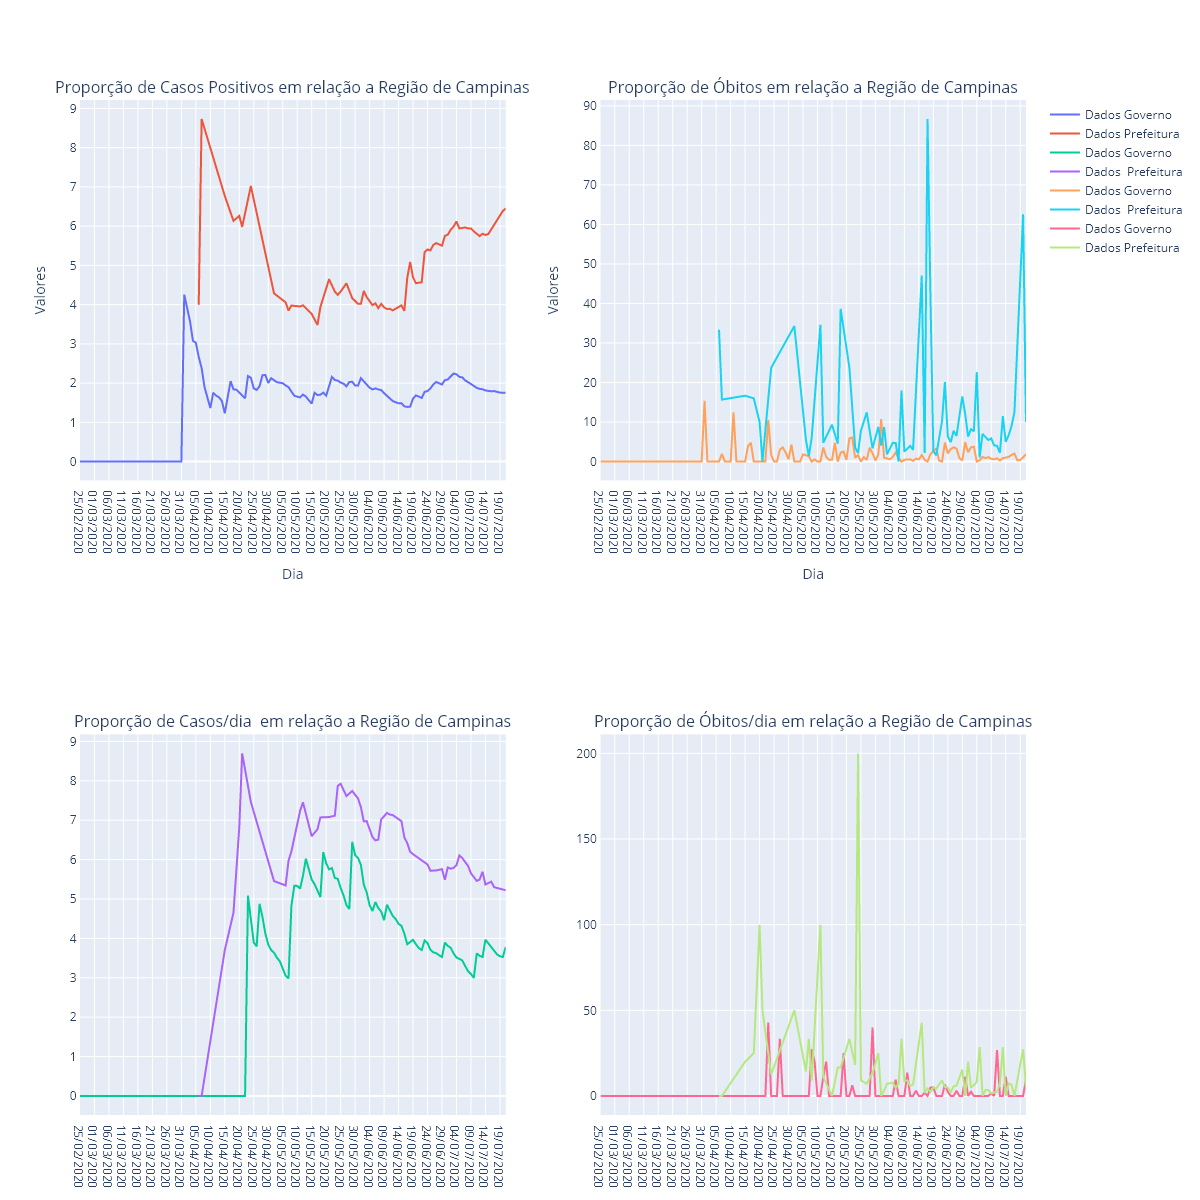

In [41]:
fig = make_subplots(rows=2, cols=2,subplot_titles = ["Proporção de Casos Positivos em relação a Região de Campinas",
                                                     "Proporção de Óbitos em relação a Região de Campinas",
                                                     "Proporção de Casos/dia  em relação a Região de Campinas",
                                                     "Proporção de Óbitos/dia em relação a Região de Campinas"])

fig.add_trace(go.Scatter(x = Dados_Governo_Indaiatuba.Data, y = Prop_Gov_Casos, mode = "lines" ,name = "Dados Governo"),row=1, col=1)
fig.add_trace(go.Scatter(x = Dados_Indaiatuba.Data, y = Prop_Pref_Casos, mode = "lines" ,name = "Dados Prefeitura"),row=1, col=1)

fig.add_trace(go.Scatter(x = Dados_Governo_Indaiatuba.Data, y = Prop_Gov_Obitos, mode = "lines" ,name = "Dados Governo"), row=2, col=1)
fig.add_trace(go.Scatter(x = Dados_Indaiatuba.Data, y = Prop_Pref_Obitos, mode = "lines" ,name = "Dados  Prefeitura"), row=2, col=1)


fig.add_trace(go.Scatter(x = Dados_Governo_Indaiatuba.Data, y = Prop_Gov_Casos_day, mode = "lines" ,name = "Dados Governo"),row=1, col=2)
fig.add_trace(go.Scatter(x = Dados_Indaiatuba.Data, y = Prop_Pref_Casos_day, mode = "lines" ,name = "Dados  Prefeitura"),row=1, col=2)


fig.add_trace(go.Scatter(x = Dados_Governo_Indaiatuba.Data, y = Prop_Gov_Obitos_day, mode = "lines" ,name = "Dados Governo"), row=2, col=2)
fig.add_trace(go.Scatter(x = Dados_Indaiatuba.Data, y = Prop_Pref_Obitos_day, mode = "lines" ,name = "Dados Prefeitura"), row=2, col=2)

fig.update_xaxes(title_text="Dia", row=1, col=1)
fig.update_xaxes(title_text="Dia", row=1, col=2)
fig.update_yaxes(title_text="Valores", row=1, col=1)
fig.update_yaxes(title_text="Valores", row=1, col=2)

fig.update_layout(
    autosize=False,
    width=1300,
    height=1000,)

fig.show(renderer="png" , width=1200, height=1200)

Analisando a média, mediana e desvio padrão dos dados da proporção. É possivel reforçar oque foi dito anteriormente maior valores de media/mediana para os dados da Prefeitura entretanto tanto casos por dia e óbitos por dia tem uma alta variabilidade, um dos motivos podem ser os resultantos são recebidos após alguns dias apenas.

In [15]:
import statistics
Data_Estat = pd.DataFrame()
Data_Estat["Media"] = [statistics.mean(Prop_Pref_Casos),statistics.mean(Prop_Pref_Casos_day),statistics.mean(Prop_Pref_Obitos),statistics.mean(Prop_Pref_Obitos_day),statistics.mean(Prop_Gov_Casos),statistics.mean(Prop_Gov_Casos_day),statistics.mean(Prop_Gov_Obitos),statistics.mean(Prop_Gov_Obitos_day)]
Data_Estat["Mediana"] = [statistics.median(Prop_Pref_Casos),statistics.median(Prop_Pref_Casos_day),statistics.median(Prop_Pref_Obitos),statistics.median(Prop_Pref_Obitos_day),statistics.median(Prop_Gov_Casos),statistics.median(Prop_Gov_Casos_day),statistics.median(Prop_Gov_Obitos),statistics.median(Prop_Gov_Obitos_day)]
Data_Estat["Desvio_padrao"] = [statistics.stdev(Prop_Pref_Casos),statistics.stdev(Prop_Pref_Casos_day),statistics.stdev(Prop_Pref_Obitos),statistics.stdev(Prop_Pref_Obitos_day),statistics.stdev(Prop_Gov_Casos),statistics.stdev(Prop_Gov_Casos_day),statistics.stdev(Prop_Gov_Obitos),statistics.stdev(Prop_Gov_Obitos_day)]

Data_Estat = Data_Estat.rename(index= {0:'Prefeitura_Casos',1:'Prefeitura_Casos_dia',2:'Prefeitura_Obitos',3:'Prefeitura_Obitos_dia',
                          4:'Governo_Casos',5:'Governo_Casos_dia',6:'Governo_Obitos',7:'Governo_Obitos_dia'})

Data_Estat

,Media,Mediana,Desvio_padrao
Prefeitura_Casos,5.038610,4.693786,1.059390
Prefeitura_Casos_dia,12.473035,6.612785,15.329581
Prefeitura_Obitos,6.123534,6.086957,1.398343
Prefeitura_Obitos_dia,16.877737,7.142857,29.788864
Governo_Casos,1.457900,1.758563,0.912109
Governo_Casos_dia,1.278853,0.365767,2.327751
Governo_Obitos,2.664520,3.552631,2.256839
Governo_Obitos_dia,2.290546,0.000000,7.179049


# Dados Semanais e Mensais

Para ver a progressão da evolução da doença de Covid-19, separamos os dados por semana e por mês.

In [16]:
#Função para separar a list pelo n
def chunks(lst, n):
    
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [17]:
#Separando por quantidade de semanas
last_value = datetime.datetime.strptime(Dados_Indaiatuba.Data.values[len(Dados_Indaiatuba.Data.values)-1], '%d/%m/%Y').strftime('%Y-%m-%d')
all_dates = pd.date_range('2020-04-06',last_value).strftime('%d/%m/%Y')

if len(all_dates)%7 == 0:
  number_groups = len(all_dates)/7
else:
  number_groups = int(len(all_dates)/7) +1

In [18]:
#Feito para fazer a junção das palavras para o eixo x do Bar-plot
words_mon = ['Abril',"Maio",'Junho','Julho','Agosto','Setembro','Outubro','Novembro','Dezembro']
words = ['Primeira semana de ',"Segunda semana de ",'Terceira semana de ','Quarta semana de ']
all_words = []
words_months = []
#for num in range(0,len(number_groups)):
aux_word = 0
while len(all_words) != number_groups:
  all_words.append(words[aux_word])
  aux_word = aux_word +1
  if aux_word == 4:
    aux_word =0

word_aux = 0
conta = 0
while len(words_months) != number_groups:
  words_months.append(words_mon[conta])
  word_aux = word_aux +1
  if word_aux == 4:
    word_aux = 0
    conta = conta + 1

all_words_final = [ x + y for x,y in zip(all_words,words_months)]

Para cada semana pegamos os dias que pertencem a essa semana e somamos os valores desejados. Para os dados do Governo temos valores para cada dia, porém para o da Prefeitura temos alguns dias da semana apenas, mas de qualquer jeito foi feito a soma. Tambem foi feito a média, nesse caso dividiamos pela quantidade de dias utilizados.

In [19]:
#Fazendo a soma dos casos e óbitos por semana
Pref_Obit_week = []
Pref_Cas_week = []
Pref_Ind_week = []
dat = list(chunks(all_dates,7))
for i in dat:
  aux_obit = 0
  aux_casos = 0
  aux_ind = 0
  for j in range(0,len(Dados_Indaiatuba.Data.values)):
    if Dados_Indaiatuba.Data.values[j] in i:
      aux_obit = aux_obit + Dados_Indaiatuba.Obitos_per_day.values[j]
      aux_casos = aux_casos + Dados_Indaiatuba.Casos_Positivos_per_day.values[j]
      aux_ind = aux_ind + 1
    
  Pref_Obit_week.append(aux_obit)
  Pref_Cas_week.append(aux_casos)
  Pref_Ind_week.append(aux_ind)

Gov_Obit_week = []
Gov_Cas_week = []
Gov_Ind_week = []

for i in dat:
  aux_obit = 0
  aux_casos = 0
  aux_ind = 0
  for j in range(0,len(Dados_Governo_Indaiatuba.Data.values)):
    if Dados_Governo_Indaiatuba.Data.values[j] in i:
      aux_obit = aux_obit + Dados_Governo_Indaiatuba.Obitos_por_dia.values[j]
      aux_casos = aux_casos + Dados_Governo_Indaiatuba.Casos_por_dia.values[j]
      aux_ind = aux_ind + 1
    
  Gov_Obit_week.append(aux_obit)
  Gov_Cas_week.append(aux_casos)
  Gov_Ind_week.append(aux_ind)

Pref_mean_Ob_week = np.array(Pref_Obit_week)/np.array(Pref_Ind_week)
Pref_mean_Caso_week = np.array(Pref_Cas_week)/np.array(Pref_Ind_week)
Gov_mean_Ob_week = np.array(Gov_Obit_week)/np.array(Gov_Ind_week)
Gov_mean_Caso_week = np.array(Gov_Cas_week)/np.array(Gov_Ind_week)

Casos mensais é analogo ao semanais porem somando todos os valores do mês.

In [20]:
Pref_Obit_month, Gov_Obit_month = [],[]
Pref_Cas_month,Gov_Cas_month  = [],[]
Pref_Ind_month,Gov_Ind_month = [],[]

for k in list(range(0, int(number_groups), 4)):
  Pref_Cas_month.append(sum(Pref_Cas_week[k:k+4]))
  Pref_Obit_month.append(sum(Pref_Obit_week[k:k+4]))
  Pref_Ind_month.append(sum(Pref_Ind_week[k:k+4]))
  Gov_Cas_month.append(sum(Gov_Cas_week[k:k+4]))
  Gov_Obit_month.append(sum(Gov_Obit_week[k:k+4]))
  Gov_Ind_month.append(sum(Gov_Ind_week[k:k+4]))

Pref_mean_Ob_month = np.array(Pref_Obit_month)/np.array(Pref_Ind_month)
Pref_mean_Caso_month = np.array(Pref_Cas_month)/np.array(Pref_Ind_month)
Gov_mean_Ob_month = np.array(Gov_Obit_month)/np.array(Gov_Ind_month)
Gov_mean_Caso_month = np.array(Gov_Cas_month)/np.array(Gov_Ind_month)

Podemos notar uma clara evolução no casos positivos, principalmente depois da segunda semana de Junho, dando relação ao inicio do Plano SP, no dados da prefeitura são muito superiores ao do Governo, mas até no dados do Governo tambem tem um crescimento. Para a  evolução das mortes teve um aumento porém continua em torno de 2 mortes por dia, tendo algumas semanas com valores maiores superiores para os dados do Governo.


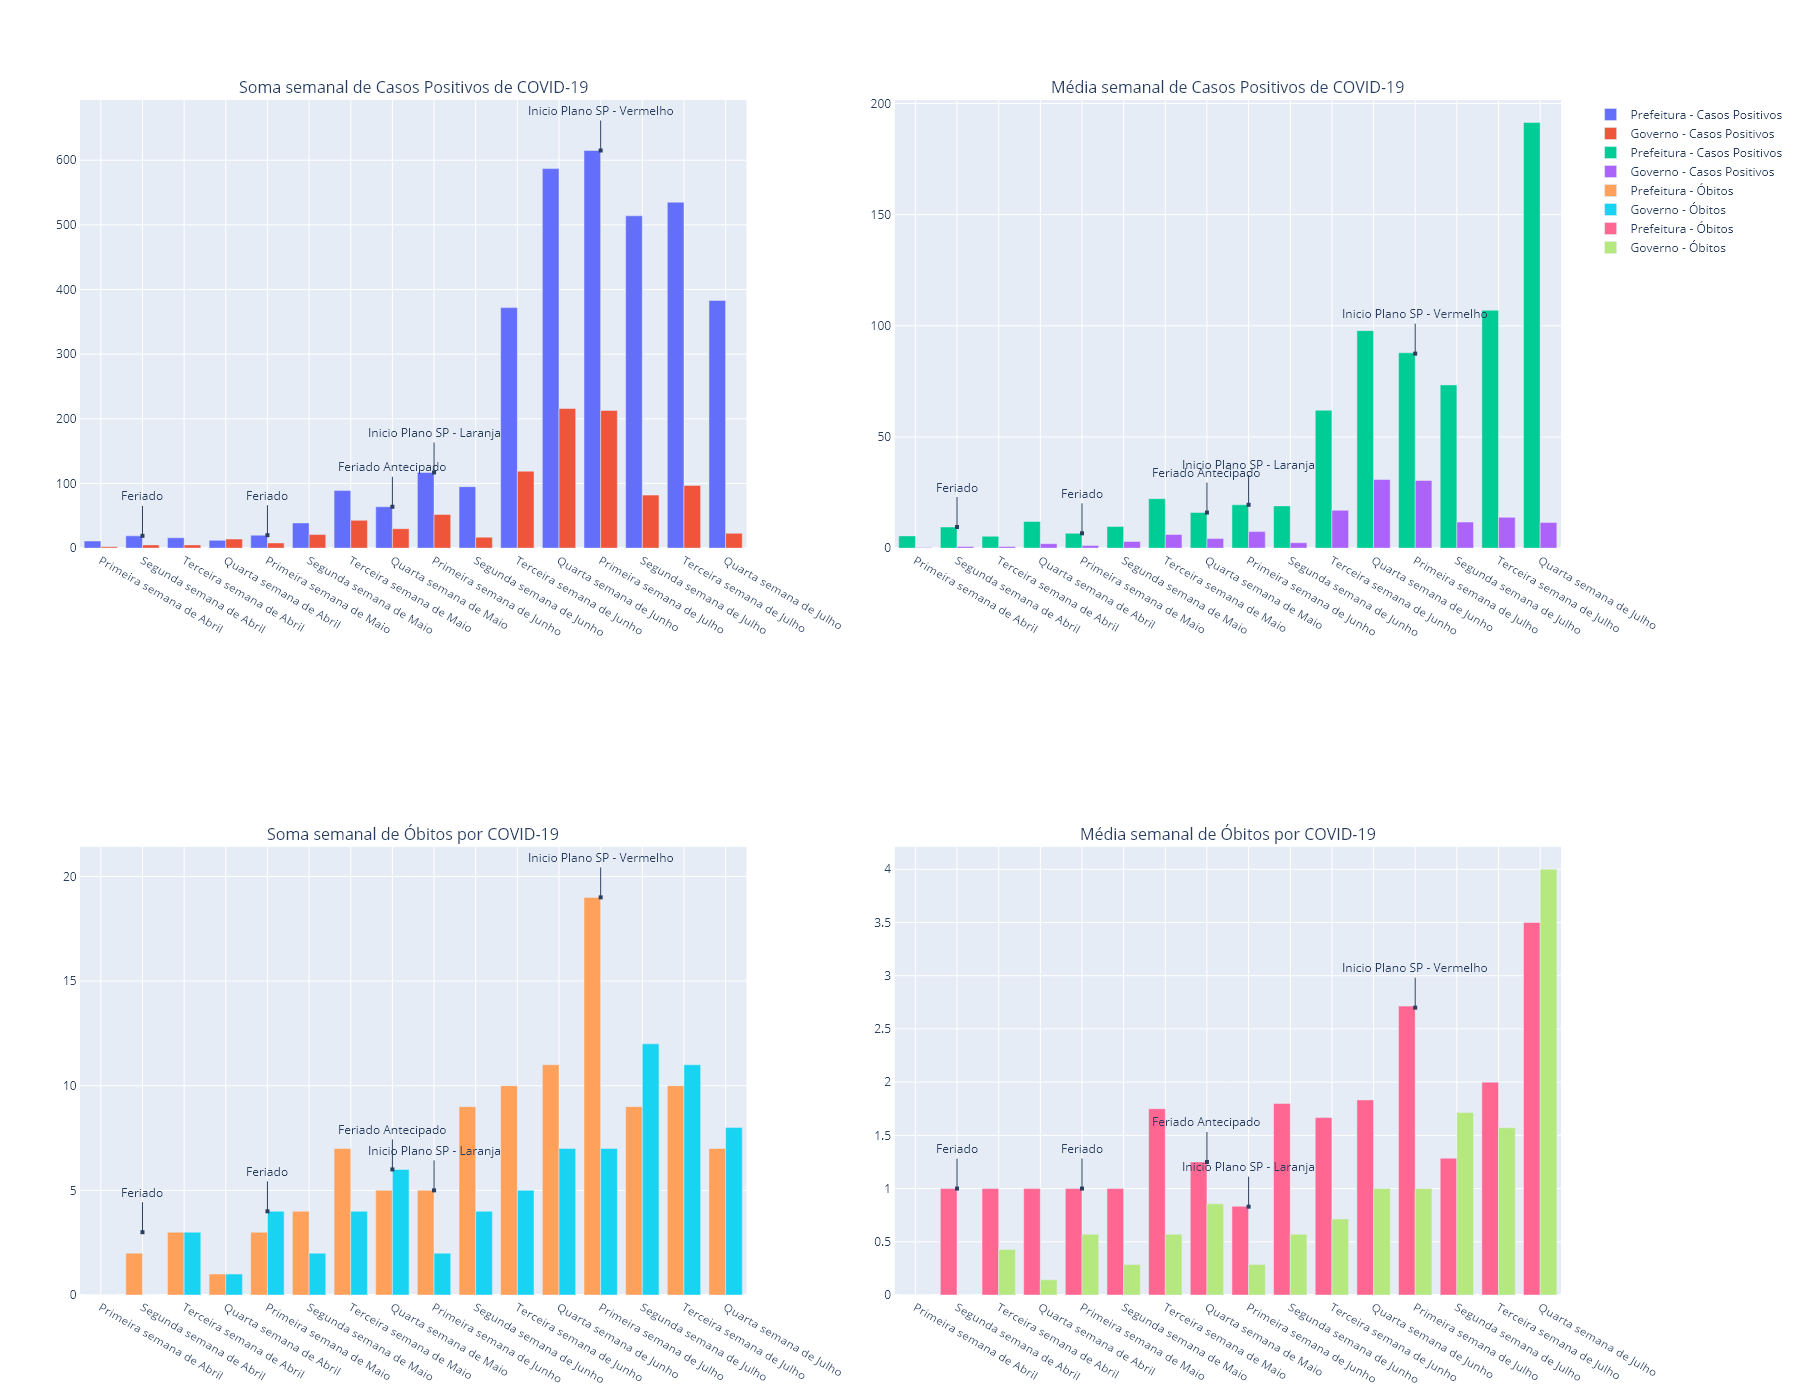

In [36]:
fig2 = make_subplots(rows=2, cols=2,subplot_titles = ["Soma semanal de Casos Positivos de COVID-19","Média semanal de Casos Positivos de COVID-19",
                                                      "Soma semanal de Óbitos por COVID-19","Média semanal de Óbitos por COVID-19"])

fig2.add_trace(go.Bar(name = 'Prefeitura - Casos Positivos',x = all_words_final, y = Pref_Cas_week),row=1, col=1)
fig2.add_trace(go.Bar(name = 'Governo - Casos Positivos',x = all_words_final, y = Gov_Cas_week),row=1, col=1)

fig2.add_annotation(x="Segunda semana de Abril",y=19,text="Feriado",xref="x", yref="y",showarrow=True,arrowhead=7,ax=0,ay=-40)
fig2.add_annotation(x="Primeira semana de Maio",y=20,text="Feriado",xref="x", yref="y",showarrow=True,arrowhead=7,ax=0,ay=-40)
fig2.add_annotation(x="Quarta semana de Maio",y=64,text="Feriado Antecipado",xref="x", yref="y",showarrow=True,arrowhead=7,ax=0,ay=-40)
fig2.add_annotation(x="Primeira semana de Junho",y=117,text="Inicio Plano SP - Laranja",xref="x", yref="y",showarrow=True,arrowhead=7,ax=0,ay=-40)
fig2.add_annotation(x="Primeira semana de Julho",y=615,text="Inicio Plano SP - Vermelho",xref="x", yref="y",showarrow=True,arrowhead=7,ax=0,ay=-40)

fig2.add_trace(go.Bar(name = 'Prefeitura - Casos Positivos',x = all_words_final, y = Pref_mean_Caso_week),row=1, col=2)
fig2.add_trace(go.Bar(name = 'Governo - Casos Positivos',x = all_words_final, y = Gov_mean_Caso_week),row=1, col=2)

fig2.add_annotation(x="Segunda semana de Abril",y=9.5,text="Feriado",xref="x2", yref="y2",showarrow=True,arrowhead=7,ax=0,ay=-40)
fig2.add_annotation(x="Primeira semana de Maio",y=6.67,text="Feriado",xref="x2", yref="y2",showarrow=True,arrowhead=7,ax=0,ay=-40)
fig2.add_annotation(x="Quarta semana de Maio",y=16,text="Feriado Antecipado",xref="x2", yref="y2",showarrow=True,arrowhead=7,ax=0,ay=-40)
fig2.add_annotation(x="Primeira semana de Junho",y=19.5,text="Inicio Plano SP - Laranja",xref="x2", yref="y2",showarrow=True,arrowhead=7,ax=0,ay=-40)
fig2.add_annotation(x="Primeira semana de Julho",y=87.5,text="Inicio Plano SP - Vermelho",xref="x2", yref="y2",showarrow=True,arrowhead=7,ax=0,ay=-40)


fig2.add_trace(go.Bar(name = 'Prefeitura - Óbitos',x = all_words_final, y = Pref_Obit_week), row=2, col=1)
fig2.add_trace(go.Bar(name = 'Governo - Óbitos',x = all_words_final, y = Gov_Obit_week), row=2, col=1)

fig2.add_annotation(x="Segunda semana de Abril",y=3,text="Feriado",xref="x3", yref="y3",showarrow=True,arrowhead=7,ax=0,ay=-40)
fig2.add_annotation(x="Primeira semana de Maio",y=4,text="Feriado",xref="x3", yref="y3",showarrow=True,arrowhead=7,ax=0,ay=-40)
fig2.add_annotation(x="Quarta semana de Maio",y=6,text="Feriado Antecipado",xref="x3", yref="y3",showarrow=True,arrowhead=7,ax=0,ay=-40)
fig2.add_annotation(x="Primeira semana de Junho",y=5,text="Inicio Plano SP - Laranja",xref="x3", yref="y3",showarrow=True,arrowhead=7,ax=0,ay=-40)
fig2.add_annotation(x="Primeira semana de Julho",y=19,text="Inicio Plano SP - Vermelho",xref="x3", yref="y3",showarrow=True,arrowhead=7,ax=0,ay=-40)

fig2.add_trace(go.Bar(name = 'Prefeitura - Óbitos',x = all_words_final, y = Pref_mean_Ob_week), row=2, col=2)
fig2.add_trace(go.Bar(name = 'Governo - Óbitos',x = all_words_final, y = Gov_mean_Ob_week), row=2, col=2)

fig2.add_annotation(x="Segunda semana de Abril",y=1,text="Feriado",xref="x4", yref="y4",showarrow=True,arrowhead=7,ax=0,ay=-40)
fig2.add_annotation(x="Primeira semana de Maio",y=1,text="Feriado",xref="x4", yref="y4",showarrow=True,arrowhead=7,ax=0,ay=-40)
fig2.add_annotation(x="Quarta semana de Maio",y=1.25,text="Feriado Antecipado",xref="x4", yref="y4",showarrow=True,arrowhead=7,ax=0,ay=-40)
fig2.add_annotation(x="Primeira semana de Junho",y=0.83,text="Inicio Plano SP - Laranja",xref="x4", yref="y4",showarrow=True,arrowhead=7,ax=0,ay=-40)
fig2.add_annotation(x="Primeira semana de Julho",y=2.7,text="Inicio Plano SP - Vermelho",xref="x4", yref="y4",showarrow=True,arrowhead=7,ax=0,ay=-40)

fig2.update_layout(
    autosize=False,
    width=1200,
    height=1050,)

fig2.show(renderer="png" , width=1800, height=1400)

Para os dados mensais temos que nos meses de Junho e Julho são superiores aos anteriores, lembrando que estamos apenas na segunda semana de Julho e os valroes são semelhantes de Junho. Quando colocamos a média mostra esse crescimento com valores 4 vezes superiores do divulgado pelo Governo.

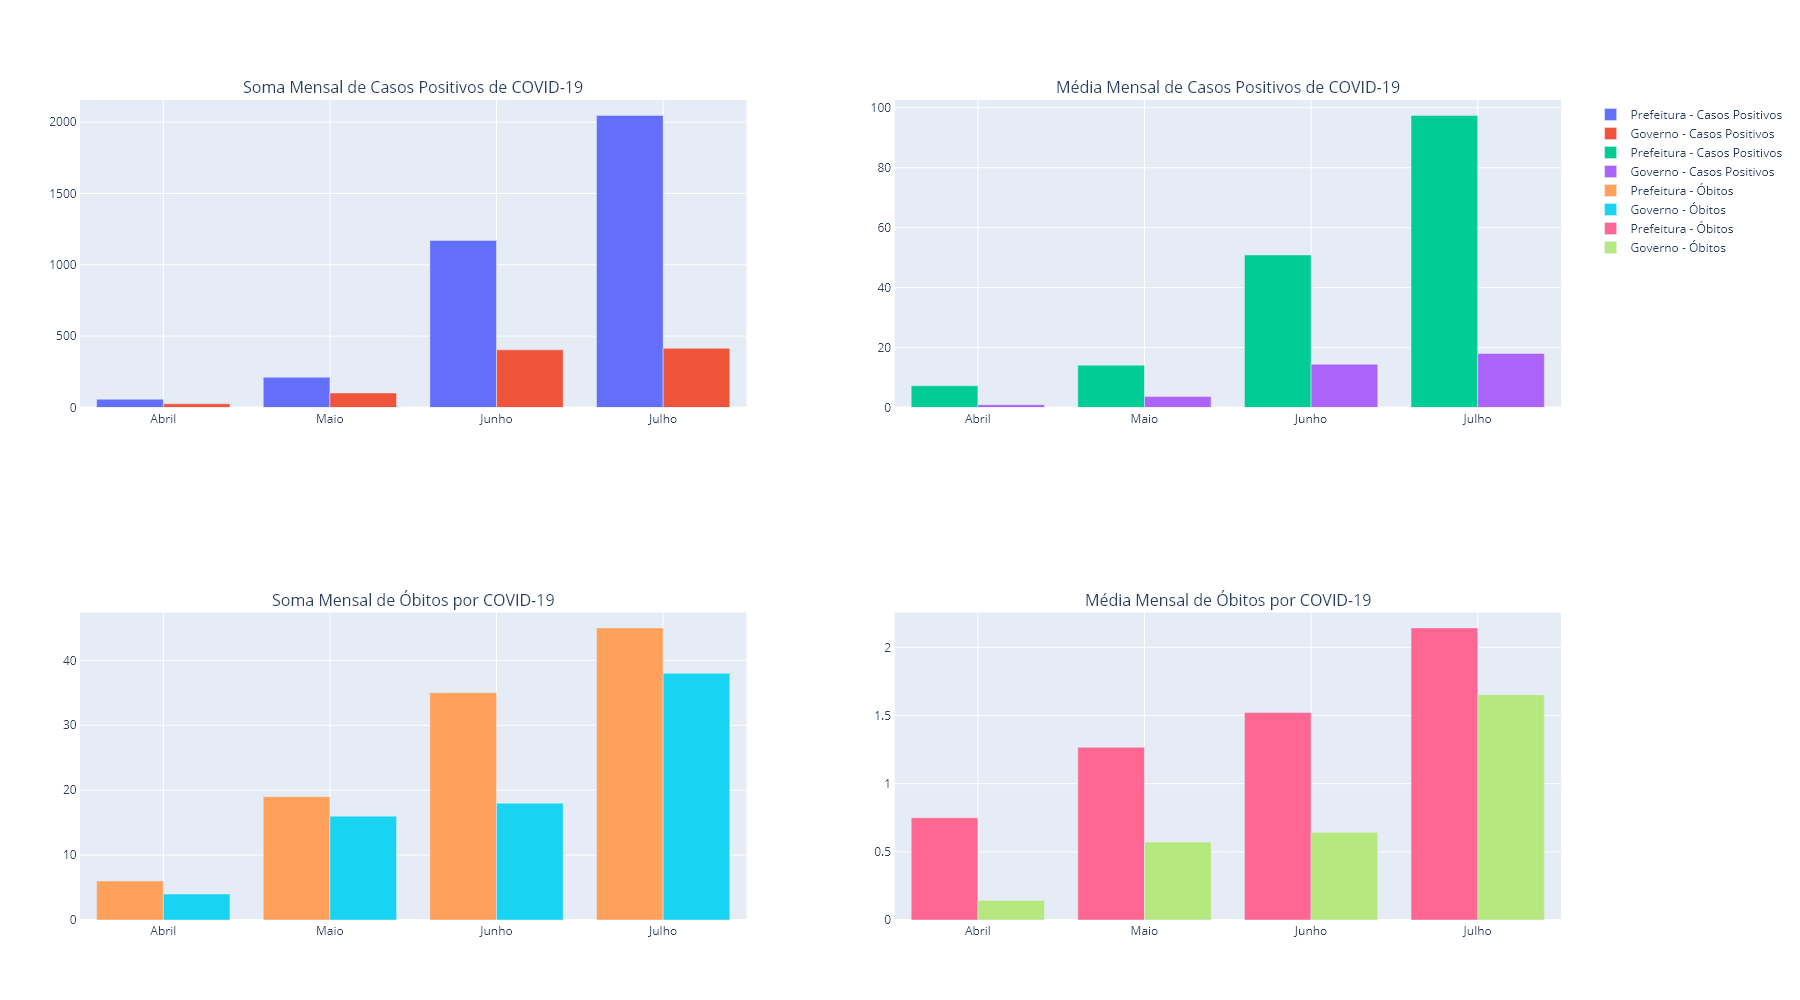

In [33]:
fig3 = make_subplots(rows=2, cols=2,subplot_titles = ["Soma Mensal de Casos Positivos de COVID-19","Média Mensal de Casos Positivos de COVID-19",
                                                      "Soma Mensal de Óbitos por COVID-19","Média Mensal de Óbitos por COVID-19"])

fig3.add_trace(go.Bar(name = 'Prefeitura - Casos Positivos',x = words_mon, y = Pref_Cas_month),row=1, col=1)
fig3.add_trace(go.Bar(name = 'Governo - Casos Positivos',x = words_mon, y = Gov_Cas_month),row=1, col=1)

fig3.add_trace(go.Bar(name = 'Prefeitura - Casos Positivos',x = words_mon, y = Pref_mean_Caso_month),row=1, col=2)
fig3.add_trace(go.Bar(name = 'Governo - Casos Positivos',x = words_mon, y = Gov_mean_Caso_month),row=1, col=2)

fig3.add_trace(go.Bar(name = 'Prefeitura - Óbitos',x = words_mon, y = Pref_Obit_month), row=2, col=1)
fig3.add_trace(go.Bar(name = 'Governo - Óbitos',x = words_mon, y = Gov_Obit_month), row=2, col=1)

fig3.add_trace(go.Bar(name = 'Prefeitura - Óbitos',x = words_mon, y = Pref_mean_Ob_month), row=2, col=2)
fig3.add_trace(go.Bar(name = 'Governo - Óbitos',x = words_mon, y = Gov_mean_Ob_month), row=2, col=2)

fig3.update_layout(
    autosize=False,
    width=1200,
    height=600,)

fig3.show(renderer="png" , width=1800, height=1000)

### **Conclusão**

Podemos concluir que os dados em que o Governo se baseia não está  proximo ao qu eestão divulgado pela prefeitura de Indaiatuba. Considerando que o Plano SP é levado em consideração essa base de dados, talvez tivessem em outro nivel no inicio do programa, além disso estamos trabalhando apenas com um municipio, seria necessario fazer uma analise de uma maior quantidade de cidade para ver qual a real diferença entre os dados. 

No G1 saiu uma pesquisa relacionado com a grande São Paulo https://g1.globo.com/sp/sao-paulo/noticia/2020/06/26/governo-de-sp-contabiliza-25-mil-casos-de-covid-19-a-menos-na-cidade-de-sp-que-prefeitura-mas-deve-liberar-fase-amarela.ghtml essa diferença poderia impactar na decisão de mudança para a fase amarela.

Proximo ponto é adicionar numero de leitos e notificações para ver se esses valores estão proximos e adicionar a porcentagem de isolamento social, entrei em contato com o instituto que está trabalhando com esses dados para ver se tem algum repositório para ser utilizado.